# Support Vector Machines

Las máquinas de vectores de soporte (SVM) son una clase particularmente poderosa y flexible de algoritmos supervisados ​​tanto para clasificación como para regresión.
En esta sección, desarrollaremos la intuición detrás de las máquinas de vectores de soporte y su uso en problemas de clasificación.

Comenzamos con las importaciones estándar:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## La motivación detras de las Support Vector Machines

La *clasificación discriminativa*: en lugar de modelar cada clase, simplemente encontramos una línea o curva (en dos dimensiones) o una variedad (en múltiples dimensiones) que divide las clases entre sí.

Como ejemplo de esto, considere el caso simple de una tarea de clasificación, en la que las dos clases de puntos están bien separadas:

/opt/tljh/user/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


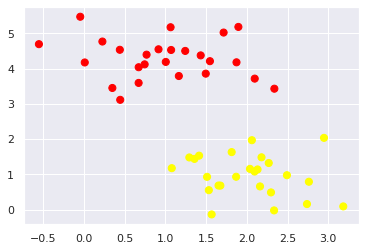

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Un clasificador discriminativo lineal intentaría trazar una línea recta que separe los dos conjuntos de datos y, por lo tanto, crearía un modelo de clasificación.
Para datos bidimensionales como el que se muestra aquí, esta es una tarea que podríamos hacer a mano.
Pero inmediatamente vemos un problema: ¡hay más de una posible línea divisoria que puede discriminar perfectamente entre las dos clases!

Podemos dibujarlos de la siguiente manera:

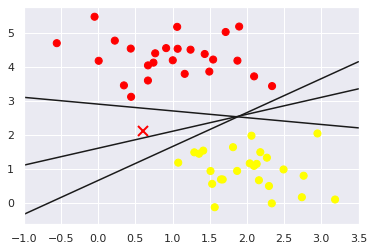

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Se trata de tres separadores *muy* diferentes que, sin embargo, discriminan perfectamente entre estas muestras.
Dependiendo de cuál elija, a un nuevo punto de datos (por ejemplo, el marcado con la "X" en este gráfico) se le asignará una etiqueta diferente.
Evidentemente, nuestra simple intuición de "trazar una línea divisoria entre clases" no es suficiente, y necesitamos pensar un poco más.

## Support Vector Machines: Maximizando el *Margen*

Las máquinas de vectores de soporte ofrecen una forma de mejorar esto.
La intuición es la siguiente: en lugar de simplemente dibujar una línea de ancho cero entre las clases, podemos dibujar alrededor de cada línea un *margen* de algún ancho, hasta el punto más cercano.
A continuación, se muestra un ejemplo de cómo podría verse esto:

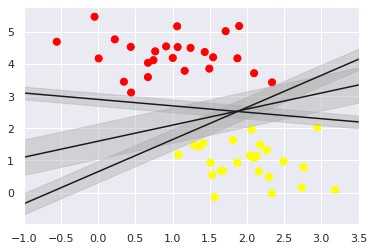

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

En máquinas de vectores de soporte, la línea que maximiza este margen es la que elegiremos como modelo óptimo.
Las máquinas de vectores de soporte son un ejemplo de un estimador de *margen máximo* de este tipo.

### Ajuste de una máquina de vectores de soporte

Veamos el resultado de un ajuste real a estos datos: utilizaremos el clasificador de vectores de soporte de Scikit-Learn para entrenar un modelo SVM sobre estos datos.
Por el momento, usaremos un kernel lineal y estableceremos el parámetro ``C'' en un número muy grande (discutiremos el significado de estos con más profundidad momentáneamente).

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Para visualizar mejor lo que está sucediendo aquí, creemos una función de conveniencia rápida que trazará los límites de decisión de SVM para nosotros:

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

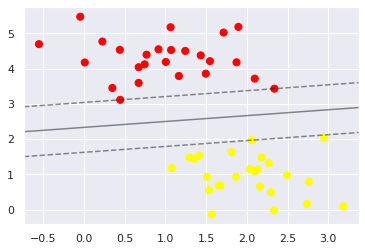

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Esta es la línea divisoria que maximiza el margen entre los dos conjuntos de puntos.
Observe que algunos de los puntos de entrenamiento solo tocan el margen: están indicados por los círculos negros en esta figura.
Estos puntos son los elementos fundamentales de este ajuste, y se conocen como * vectores de soporte*, y dan nombre al algoritmo.
En Scikit-Learn, la identidad de estos puntos se almacena en el atributo `` support_vectors_``  del clasificador:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Una clave del éxito de este clasificador es que para el ajuste, solo importa la posición de los vectores de soporte; ¡Cualquier punto más alejado del margen que esté en el lado correcto no modifica el ajuste!
Técnicamente, esto se debe a que estos puntos no contribuyen a la función de pérdida utilizada para ajustar el modelo, por lo que su posición y número no importan siempre que no crucen el margen.

Podemos ver esto, por ejemplo, si graficamos el modelo aprendido de los primeros 60 puntos y los primeros 120 puntos de este conjunto de datos:

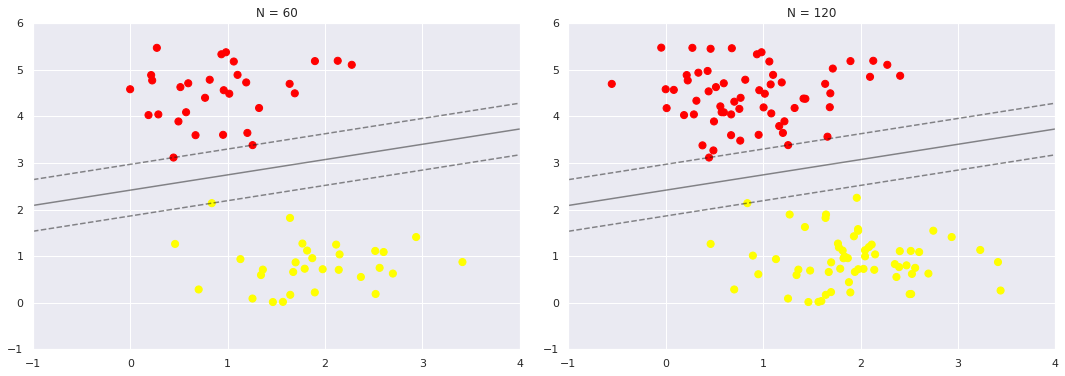

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

En el panel de la izquierda vemos el modelo y los vectores de soporte para 60 puntos de entrenamiento.
En el panel derecho, hemos duplicado el número de puntos de entrenamiento, pero el modelo no ha cambiado: los tres vectores de apoyo del panel izquierdo siguen siendo los vectores de apoyo del panel derecho.
Esta insensibilidad al comportamiento exacto de puntos distantes es uno de los puntos fuertes del modelo SVM.

Si está ejecutando este cuaderno en vivo, puede utilizar los widgets interactivos de IPython para ver esta función del modelo SVM de forma interactiva:

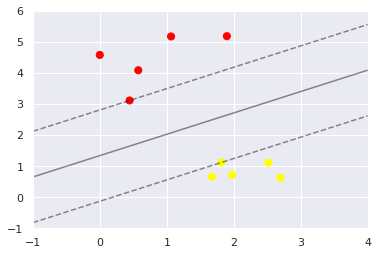

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 50, 100, 150, 200], ax=fixed(None));

## <font color='green'>**Actividad 1**</font>

Entrene una SVM para clasificar correctamente los datos de abajo.

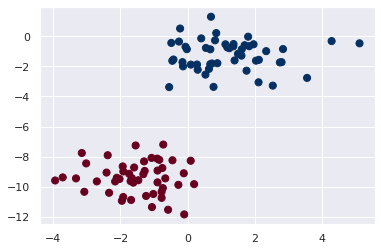

In [11]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

Ajuste la SVM con un kernel lineal.

Grafique los puntos y el plano separador.

## <font color='green'>**Fin Actividad 1**</font>

### Más allá de los límites lineales: Kernel SVM

Donde SVM se vuelve extremadamente poderoso es cuando se combina con * kernels *.

Allí proyectamos nuestros datos en un espacio de dimensiones superiores definido por polinomios y funciones de base gaussiana, y por lo tanto pudimos ajustarnos a relaciones no lineales con un clasificador lineal.

En los modelos SVM, podemos usar una versión de la misma idea.
Para motivar la necesidad de kernels, veamos algunos datos que no se pueden separar linealmente:

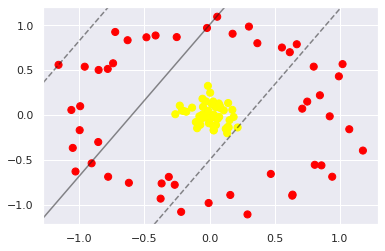

In [12]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Está claro que ninguna discriminación lineal * jamás * podrá separar estos datos.
Pero podemos sacar una lección de las regresiones de funciones base, y pensar en cómo podríamos proyectar los datos en una dimensión superior de modo que un separador lineal * haría * Ser suficiente.
Por ejemplo, una proyección simple que podríamos usar sería calcular una * función de base radial * centrada en el grupo medio:

In [13]:
r = np.exp(-(X ** 2).sum(1))

Podemos visualizar esta dimensión de datos adicional utilizando un gráfico tridimensional; si está ejecutando este cuaderno en vivo, podrá usar los controles deslizantes para rotar el gráfico:

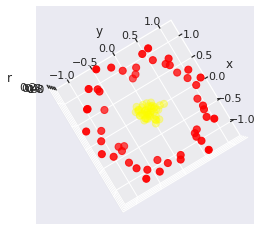

In [14]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90,0, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

Podemos ver que con esta dimensión adicional, los datos se vuelven trivialmente separables linealmente, dibujando un plano de separación en, digamos, * r * = 0,7.

Aquí tuvimos que elegir y ajustar cuidadosamente nuestra proyección: si no hubiéramos centrado nuestra función de base radial en la ubicación correcta, no hubiéramos visto resultados tan limpios y linealmente separables.
En general, la necesidad de hacer tal elección es un problema: nos gustaría de alguna manera encontrar automáticamente las mejores funciones de base para usar.

Una estrategia para este fin es calcular una función de base centrada en * cada * punto en el conjunto de datos y dejar que el algoritmo SVM tamice los resultados.
Este tipo de transformación de función base se conoce como * transformación de núcleo *, ya que se basa en una relación de similitud (o núcleo) entre cada par de puntos.

Un problema potencial con esta estrategia, proyectar $ N $ puntos en dimensiones de $ N $, es que podría volverse muy intensiva en computación a medida que $ N $ crezca.
Sin embargo, debido a un pequeño procedimiento conocido como el [*truco del kernel*] (https://en.wikipedia.org/wiki/Kernel_trick), se puede hacer un ajuste en los datos transformados por el kernel de manera implícita, es decir, sin construyendo la representación completa $ N $ -dimensional de la proyección del kernel!
Este truco del kernel está integrado en SVM y es una de las razones por las que el método es tan poderoso.

En Scikit-Learn, podemos aplicar SVM kernelizado simplemente cambiando nuestro kernel lineal a un kernel RBF (función de base radial), usando el hiperparámetro del modelo `` kernel '':

In [15]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

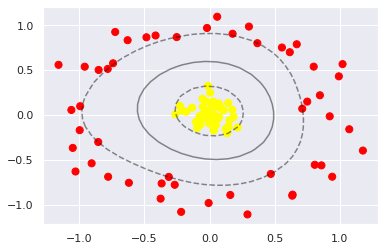

In [16]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Usando esta máquina de vectores de soporte kernelizada, aprendemos un límite de decisión no lineal adecuado.
Esta estrategia de transformación del kernel se usa a menudo en el aprendizaje automático para convertir métodos lineales rápidos en métodos no lineales rápidos, especialmente para modelos en los que se puede usar el truco del kernel.

### Tuning the SVM: Softening Margins

Hasta ahora, nuestra discusión se ha centrado en conjuntos de datos muy limpios, en los que existe un límite de decisión perfecto.
Pero, ¿qué pasa si sus datos tienen cierta superposición?
Por ejemplo, puede tener datos como este:

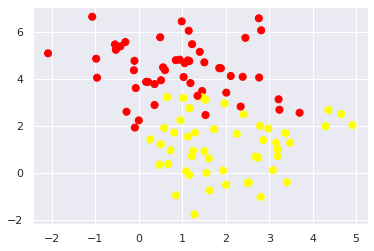

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Para manejar este caso, la implementación de SVM tiene un pequeño factor de modificación que "suaviza" el margen: es decir, permite que algunos de los puntos se introduzcan en el margen si eso permite un mejor ajuste.
La dureza del margen se controla mediante un parámetro de ajuste, más conocido como $ C $.
Para $ C $ muy grandes, el margen es difícil y los puntos no pueden estar en él.
Para $ C $ más pequeños, el margen es más suave y puede crecer hasta abarcar algunos puntos.

El gráfico que se muestra a continuación ofrece una imagen visual de cómo un parámetro $ C $ cambiante afecta el ajuste final, a través del ablandamiento del margen:

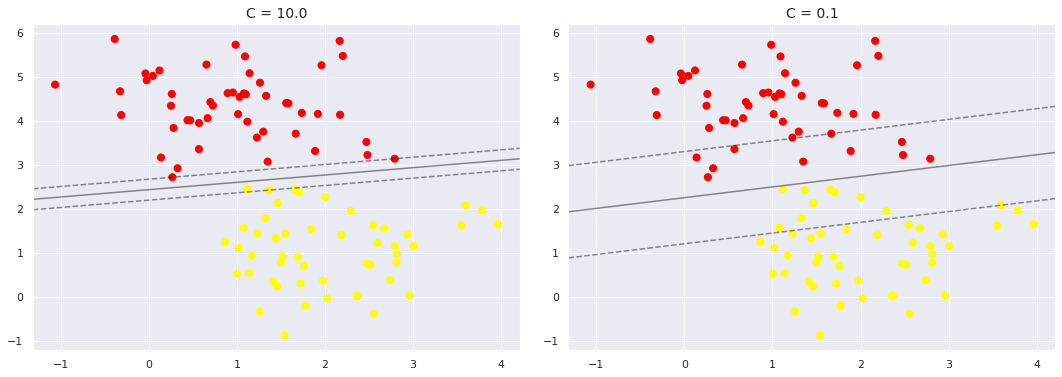

In [18]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

El valor óptimo del parámetro $ C $ dependerá de su conjunto de datos y debe ajustarse mediante validación cruzada o un procedimiento similar.

## <font color='green'>**Actividad 2**</font>

In [19]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.3, noise=.2)

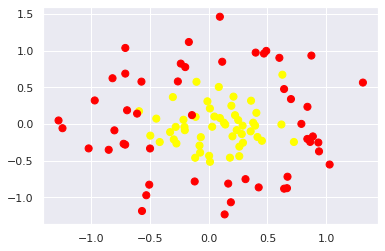

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

Genere un modelo de SVM con kernel RBF. 

Grafique el resultado y muestre el limite de decisión y su margen. 

## <font color='green'>**Fin Actividad 2**</font>

## Otro Ejemplo

In [21]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm

iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y != 0, :2]
y = y[y != 0]

n_sample = len(X)

np.random.seed(0)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(float)

X_train = X[:int(.9 * n_sample)]
y_train = y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
y_test = y[int(.9 * n_sample):]

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with

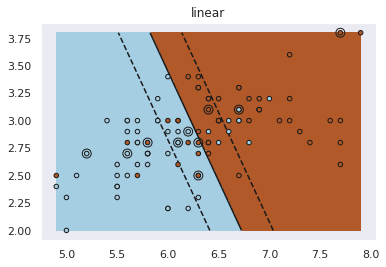

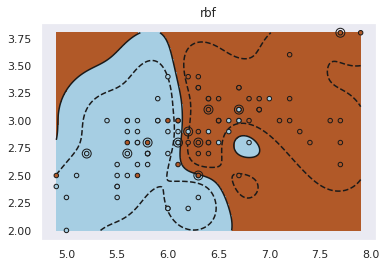

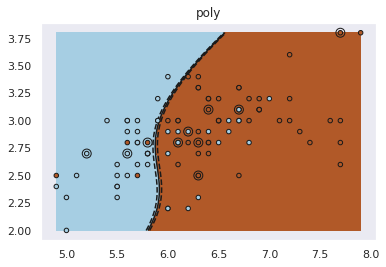

In [22]:
for kernel in ('linear', 'rbf', 'poly'):
    clf = svm.SVC(kernel=kernel, gamma=10)
    clf.fit(X_train, y_train)

    plt.figure()
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none',
                zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
plt.show()

## Example: Face Recognition

Como ejemplo de máquinas de vectores de soporte en acción, echemos un vistazo al problema del reconocimiento facial.
Usaremos el conjunto de datos de Caras etiquetadas, que consta de varios miles de fotos recopiladas de varias figuras públicas.
Un buscador para el conjunto de datos está integrado en Scikit-Learn:

In [23]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Tracemos algunas de estas caras para ver con qué estamos trabajando:

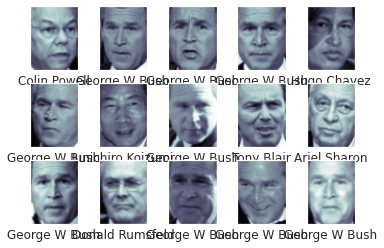

In [24]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Cada imagen contiene [62 × 47] o casi 3000 píxeles.
Podríamos proceder simplemente usando cada valor de píxel como una característica, pero a menudo es más efectivo usar algún tipo de preprocesador para extraer características más significativas; aquí usaremos un análisis de componentes principales para extraer 150 componentes fundamentales para alimentar a nuestro clasificador de máquina de vectores de soporte. El detalle de PCA lo veremos en el siguiente módulo.
Podemos hacer esto de la manera más sencilla empaquetando el preprocesador y el clasificador en un único Pipeline:

In [25]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Para probar la salida de nuestro clasificador, dividiremos los datos en un conjunto de entrenamiento y prueba:

In [26]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finalmente, podemos usar una validación cruzada de búsqueda de cuadrícula para explorar combinaciones de parámetros.
Aquí ajustaremos `` C '' (que controla la dureza del margen) y `` gamma '' (que controla el tamaño del kernel de la función de base radial), y determinaremos el mejor modelo:

In [27]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [0.1, 1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid,scoring="accuracy")

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 8min 26s, sys: 12min 44s, total: 21min 11s
Wall time: 4min 28s
{'svc__C': 10, 'svc__gamma': 0.001}


Los valores óptimos caen hacia el medio de nuestra cuadrícula; si cayeran en los bordes, querríamos expandir la cuadrícula para asegurarnos de haber encontrado el verdadero óptimo.

Ahora, con este modelo de validación cruzada, podemos predecir las etiquetas de los datos de prueba, que el modelo aún no ha visto:

In [28]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Echemos un vistazo a algunas de las imágenes de prueba junto con sus valores predichos:

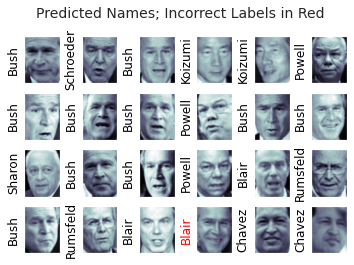

In [29]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

De esta pequeña muestra, nuestro estimador óptimo etiquetó erróneamente solo una cara (la de Bush
La cara de la fila inferior estaba mal etiquetada como Blair).
Podemos tener una mejor idea del rendimiento de nuestro estimador utilizando el informe de clasificación, que enumera las estadísticas de recuperación etiqueta por etiqueta:

In [30]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



También podríamos mostrar la matriz de confusión entre estas clases:

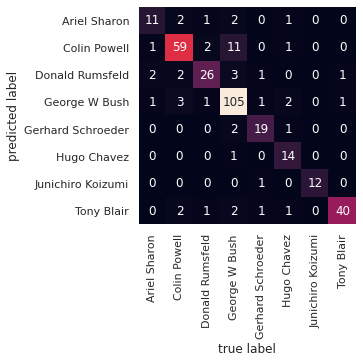

In [31]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Esto nos ayuda a tener una idea de qué etiquetas es probable que el estimador confunda.

Para una tarea de reconocimiento facial del mundo real, en la que las fotos no vienen recortadas en cuadrículas agradables, la única diferencia en el esquema de clasificación facial es la selección de características: necesitaría usar un algoritmo más sofisticado para encontrar las caras, y extraer características que sean independientes de la pixelación.
Para este tipo de aplicación, una buena opción es hacer uso de [OpenCV] (http://opencv.org), que, entre otras cosas, incluye implementaciones previamente entrenadas de herramientas de extracción de características de última generación para imágenes en general y rostros en particular.

## Support Vector Machine Summary

Hemos visto aquí una breve introducción intuitiva a los principios detrás de las máquinas de vectores de soporte.
Estos métodos son un método de clasificación poderoso por varias razones:

- Su dependencia de relativamente pocos vectores de soporte significa que son modelos muy compactos y ocupan muy poca memoria.
- Una vez entrenado el modelo, la fase de predicción es muy rápida.
- Debido a que solo se ven afectados por puntos cercanos al margen, funcionan bien con datos de alta dimensión, incluso datos con más dimensiones que muestras, lo cual es un régimen desafiante para otros algoritmos.
- Su integración con los métodos del kernel los hace muy versátiles, capaces de adaptarse a muchos tipos de datos.

Sin embargo, las SVM también tienen varias desventajas:

- La escala con el número de muestras $ N $ es $ \mathcal{O} [N ^ 3] $ en el peor de los casos, o $ \mathcal {O} [N ^ 2] $ para implementaciones eficientes. Para un gran número de muestras de formación, este coste computacional puede resultar prohibitivo.
- Los resultados dependen en gran medida de una elección adecuada para el parámetro de suavizado $ C $. Esto debe elegirse cuidadosamente a través de la validación cruzada, que puede ser costosa a medida que los conjuntos de datos aumentan de tamaño.
- Los resultados no tienen una interpretación probabilística directa. Esto puede estimarse mediante una validación cruzada interna (consulte el parámetro de `` probabilidad '' de `` SVC ''), pero esta estimación adicional es costosa.

Con esos rasgos en mente, generalmente solo recurro a las SVM una vez que se ha demostrado que otros métodos más simples, rápidos y menos intensivos en ajustes son insuficientes para mis necesidades.
Sin embargo, si tiene los ciclos de CPU para comprometerse con el entrenamiento y la validación cruzada de una SVM en sus datos, el método puede generar excelentes resultados.

## <font color='green'>**Actividad 3**</font>

Descargar el dataset ''Adult'' [UCI Machine Learning](https://archive.ics.uci.edu/ml/datasets/Adult). Leer la documentacion del conjunto de datos para definir la tarea a realizar. 

Realice el procesamiento para que los datos queden en un formato "digerible" por la SVM.

In [33]:
import io
import pandas as pd
import requests
url="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')))

Separe el conjunto de datos en entrenamiento y test



In [34]:
data

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Encuentre los mejores parámetros con GridSearchCV (C, gamma, kernel, degree, etc.)

Realice un 5 fold cross validation y reporte los resultados de 20 experimentos. Reporte la medida de desempeño F1.

Genere un reporte de clasificacion.

## <font color='green'>**Fin Actividad 3**</font>